# Machine Learning Nanodegree

## Project: Movie Review Calssifier

<p style="text-align:justify">This project is based on Sentiment analysis, which is also called opinion analysis, is a subdiscipline of the Natural Language Processing; it analyzes the polarity of documents. He we wil be working on a large dataset of movie reviews from the **Internet Movie Database (IMDb)**. Which consists of 50,000 movie reviews that are labeled as either positive or negative. Here, positive means that a movie was rated with more than six stars and negative means that a movie was rated below five stars, neutral reviews are not included in the datset.</p>

## Load Dataset

> * <p style="text-align:justify">Make sure your data is prepared before loading, use prepare_data.ipynb notebook to prepare data.</p>
> * <p style="text-align:justify"> Let us confirm that we successfully saved the data in the rigth format
    by loading the CSV file. </p>

In [1]:
import pandas as pd

# Load data
dataframe = pd.read_csv('./movie_reviews_data.csv')

# Display a chunk of data
dataframe.head()

,review,sentiment
0,"Election is a Chinese mob movie, or triads in ...",1
1,I was just watching a Forensic Files marathon ...,0
2,Police Story is a stunning series of set piece...,1
3,"Dear Readers,<br /><br />The final battle betw...",1
4,I have seen The Perfect Son about three times....,1


## Data Distribution
<p style="text-align:justify">The Internet Movie Database (IMDb) dataset consists of 50,000 movie reviews that are labeled as either positive or negative. From the below vizualization we can clearly see that the provided dataset is 25000 data points of postive reviews and 25000 data points of negative reviews.</p>

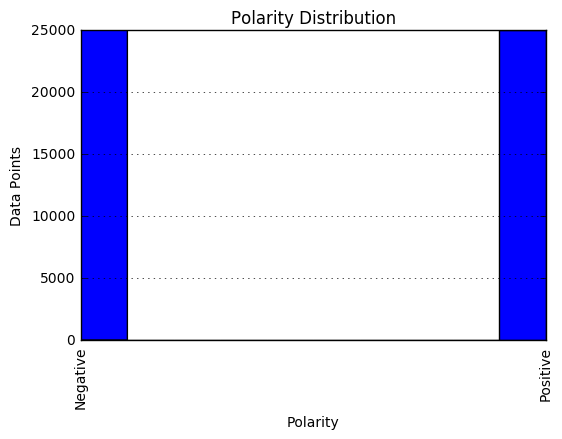

In [2]:
import matplotlib.pyplot as plt
import numpy as np
# Load the polarity data
x = dataframe['sentiment']

labels = ['Negative', 'Positive']
plt.xlabel('Polarity')
plt.ylabel('Data Points')
plt.title("Polarity Distribution")
plt.hist(x)
#plt.xticks(x, labels, rotation='vertical')
plt.xticks(np.arange(0,2,1), labels, rotation='vertical')
plt.grid(True)
plt.show()

## Cleaning text data

* <p style="text-align:justify">Before we build our bag-of-words model we need to clean our text data by removing HTML markup as well as puncuation and other non-latter characters present in the reviews text.</p>
* <p style="text-align:justify">For this purpose we will use Python's regular expression (regex) library.</p>

In [3]:
import re # regular expression

# import nltk
# nltk.download(stopwords)

from nltk.corpus import stopwords

# Load the downloaded english stop words
stop = stopwords.words('english')

def tokenizer(text):
    """ Returns clean and tokenized text words. """
    text = re.sub('<[^>]*>', '', text)
    emos = re.findall('(?::|;}=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +' '.join(emos).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

def stream(path):
    """ A generator function that reads in and returns one document at a time """
    with open(path, 'r') as csv:
        next(csv)
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

def minibatch(stream, size):
    """Returns a perticular number of documents specified by the size parameter """
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
            return None, None
    return docs, y

# Transforming words into feature vectors and classification

## Bag-of-words model

* <p style="text-align:justify">To transform an array of text data into a bag-of-words, we use HashingVectorizer and CountVectorizer classes implemented in scikit-learn.</p>
* <p style="text-align:justify">HashingVectorizer is data-independent unlike CountVectorizer.</p>

## Classification
* <p style="text-align:justify">Let us initialize the logestic regression classifier by setting the loss prameter of the SGDClassifier to log.</p>
* <p style="text-align:justify">Let us also test the classification performences by Support Vector Machines and Naive Baye's classifiers.</p>

In [16]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

""" Initialize Hashingvectorizer with our tokenizer function and features """
vect = HashingVectorizer(decode_error="ignore",
                        n_features=2**21,
                        preprocessor=None,
                        tokenizer=tokenizer)

# Convert words to vectors for Navie Baye's classifier
vectorizer = CountVectorizer(stop_words='english')

# Logistic Regression
clf1 = SGDClassifier(loss = 'log', random_state=1, n_iter=1)

# Support Vector Machines
clf2 = SGDClassifier(loss = 'hinge', penalty='l2', random_state=1, n_iter=1)

# Naive Baye's
clf3 = MultinomialNB()

doc_stream = stream(path='./movie_reviews_data.csv')

# Out-of-core Learning

<p style="text-align:justify"> Out-of-core or external memory algorithms are algorithms that are designed to process data that is too large to fit into a computer's main memory at one time. </p>

> * <p style="text-align:justify">Let us initialize the progress indicator in order to estimate the progress of our learning model.</p>
> * <p style="text-align:justify">The progress indicator with 45 iterations, which loops for 45 minibatches (1000 documents for minibatch) of documents.</p>

In [17]:
import pyprind
import numpy as np

# Progress Indicator
pper = pyprind.ProgPercent(45)

classes = np.array([0,1])

# Iterate 1000 documents for every batch total of 45,000 documents
for _ in range(45):
    X_train, y_train = minibatch(doc_stream, size=1000)
    if not X_train:
        break
    # Transform the words into vectors
    X_train1 = vectorizer.fit_transform([r for r in X_train])
    X_train = vect.transform(X_train)
    
    # Fit the classifiers
    clf1.partial_fit(X_train, y_train, classes=classes)
    clf2.partial_fit(X_train, y_train, classes=classes)
    clf3.fit(X_train1, y_train)
    
    pper.update()

[100 %] Time elapsed: 00:04:04 | ETA: 00:00:00
Total time elapsed: 00:04:04


## Evaluate the performance

<p style="text-align:justify"> Performance measure is the way you want to evaualte a solution to the problem. It is the measurement you will make of the predictions made by a trained model on the test dataset.</p>
> * Let us evaluate the performance of our model using the last 5000 documents.
> * Calculate the classification accuracies of the three classifiers

In [18]:
"""
    Let us stream and evaluate our model using last 5000 documents.
"""
X_test, y_test = minibatch(doc_stream, size=5000)
X_test1 = vectorizer.transform([j for j in X_test])
X_test = vect.transform(X_test)

lg_acc = clf1.score(X_test, y_test)
svm_acc = clf2.score(X_test, y_test)
nb_acc = clf3.score(X_test1, y_test)
# Accuracies 
print 'Logistic Regression Accuracy: {:.3f}'.format(lg_acc)
print 'SVM Accuracy: {:.3f}'.format(svm_acc)
print 'Naive Bayes Accuracy: {:.3f}'.format(nb_acc)

Logistic Regression Accuracy: 0.866
SVM Accuracy: 0.873
Naive Bayes Accuracy: 0.803


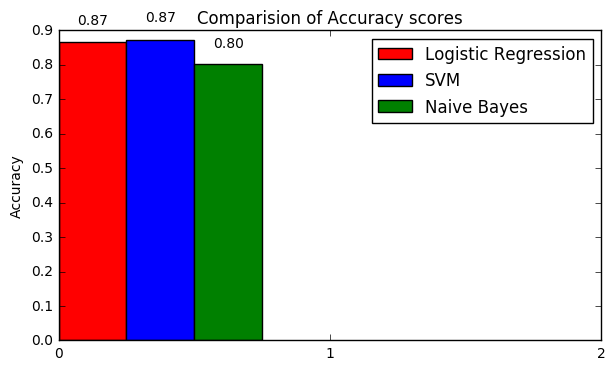

In [29]:
N = 1

ind = np.arange(N)
width = 0.25

fig, ax = plt.subplots(figsize=(7, 4))

bar1 = ax.bar(ind, lg_acc, width, color='r')

bar2 = ax.bar(ind+width, svm_acc, width, color='b')

bar3 = ax.bar(ind+width*2, nb_acc, width, color='g')

ax.set_ylabel('Accuracy')
ax.set_title('Comparision of Accuracy scores')
ax.set_xticks(np.arange(0,3,1))
#ax.set_xticklabels(('Logistic Regression', 'SVM', 'Naive Bayes' ))
ax.set_yticks(np.arange(0.0,1.0, 0.1))
ax.legend((bar1[0],bar2[0],bar3[0]),('Logistic Regression','SVM','Naive Bayes'))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.2f' % (height),
                ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)
autolabel(bar3)


plt.show()

# Predicitons and Metrics:
* <p style="text-align:justify">Let us make predictions with the remaining 5000 documetns.</p>
* <p style="text-align:justify">Calculate:</p>
  * **Recall**
  * **Precision**
  * **F-Score**

In [67]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Predictions of three classifiers
y_pred1 = clf1.predict(X_test)
y_pred2 = clf2.predict(X_test)
y_pred3 = clf3.predict(X_test1)

# Calculate scores of each classifier
lg = precision_recall_fscore_support(y_test, y_pred1, average='binary')
svm = precision_recall_fscore_support(y_test, y_pred2, average='binary')
nb = precision_recall_fscore_support(y_test, y_pred3, average='binary')

# Print scores
print 'Logistic regression Precision: {:.2f}, Recall: {:.2f}, F-Score: {:.2f}'.format(lg[0],lg[1],lg[2])
print 'SVM Precision: {:.2f}, Recall: {:.2f}, F-Score: {:.2f}'.format(svm[0],svm[1],svm[2])
print 'Naive Bayes Precision: {:.2f}, Recall: {:.2f}, F-Score: {:.2f}'.format(nb[0],nb[1],nb[2])



Logistic regression Precision: 0.88, Recall: 0.84, F-Score: 0.86
SVM Precision: 0.91, Recall: 0.82, F-Score: 0.86
Naive Bayes Precision: 0.85, Recall: 0.70, F-Score: 0.77


## Plot and compare the scores

<p style="text-align:justify"> We have calculated the precision, recall and f-scores of Logistic Regression, SVM and Naive Bayes models. Let us plot the calculated scores.</p>
> **Note:** The basic rule to choose a best classifier is the recall and f-socres should be higher and the precision value should be lower

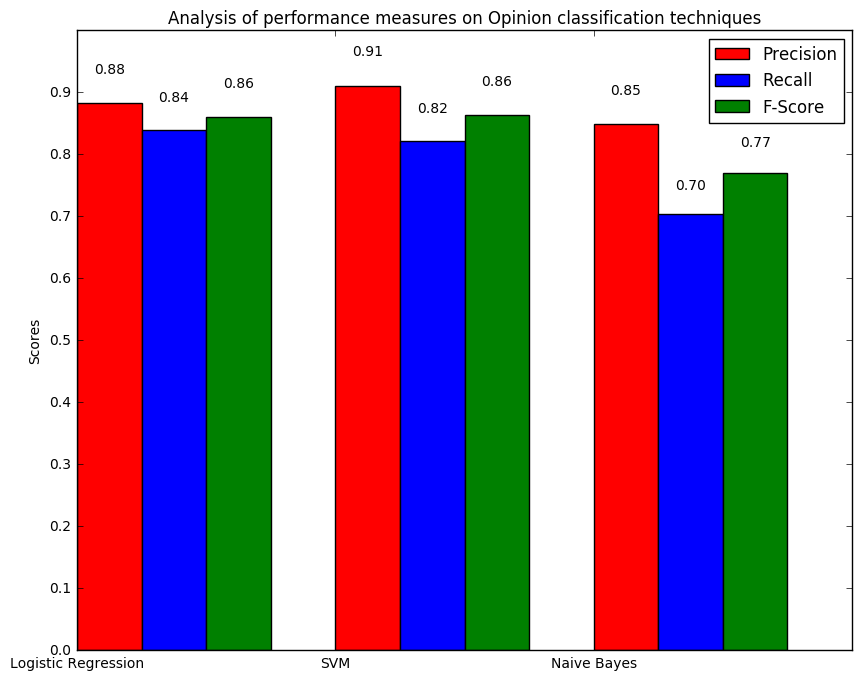

In [68]:

def split_scores(i):
    return [lg[i],svm[i],nb[i]]

precision = split_scores(0)
recall = split_scores(1)
f_score = split_scores(2)


"""
  Let us plot and compare the calulated precision, recall and f-scores of each the classifier.
"""

N = 3

ind = np.arange(N)
width = 0.25

fig, ax = plt.subplots(figsize=(10, 8))

bar1 = ax.bar(ind, precision, width, color='r')

bar2 = ax.bar(ind+width, recall, width, color='b')

bar3 = ax.bar(ind+width*2, f_score, width, color='g')

ax.set_ylabel('Scores')
ax.set_title('Analysis of performance measures on Opinion classification techniques')
ax.set_xticks(np.arange(0,3,1))
ax.set_xticklabels(('Logistic Regression', 'SVM', 'Naive Bayes' ))
ax.set_yticks(np.arange(0.0,1.0,0.1))
ax.legend((bar1[0],bar2[0],bar3[0]),('Precision','Recall','F-Score'))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.2f' % (height),
                ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)
autolabel(bar3)


plt.show()

# Choosing a model

<p style="text-align:justify"> By comparing the scores of the three classification models, I choose Logistic Regression model for my project use. As it has better recall and f-scores compared to SVM and Naive Bayes models and also accuracy achieved by the Logistic Regression model is of 86 percent.</p>

> Let us fit the last 5,000 documents to update our model.


In [69]:
clf1.partial_fit(X_test,y_test)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=1, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=1, shuffle=True, verbose=0,
       warm_start=False)

## Saving current state for our classifier

<p style="text-align:justify">We don't want to train our Machine Learning model every time we close our Python interpretor or notebook. With the use of Pythons in-built pickle module we can serialize and deserialize Python object structers to compact byte code. So we can save the current state of our classifier and we can reload it when ever we need to use in future.</p>

In [70]:
import pickle
import os

# Create a reviewclassifier directory and pkl_objects subdirectory
dest = os.path.join('reviewclassifier', 'pkl_objects')

if not os.path.exists(dest):
    os.makedirs(dest)

# Save serialized Python objects using pickle's dump method
pickle.dump(stop,
           open(os.path.join(dest, 'stopwords.pkl'), 'wb'),
           protocol=2)
pickle.dump(clf1,
           open(os.path.join(dest, 'classifier.pkl'), 'wb'),
           protocol=2)

# Further Directions

<p style="text-align:justify"> The is no need to save the HashigVectorizer, since it does not need to be fitted. Here I created a Python script file vectorizer.py, from which we can import into our current session.</p>

> We have pickled the Python objects and created a script file, now we can test the object by deserializing them.
> * Restart the IPython Notebook 
> * Navigate to reviewclassifer directory
> * Load sqlite_setup.ipynb notebook file